In [6]:
import configparser
import pandas as pd
import matplotlib.pyplot as plt

from pyspn.components import spn_visualization, spn_io

from components.ModelGenerator import ModelGenerator
from components.ModelValidator import ModelValidator
from components.ModelManipulator import ModelManipulator

In [7]:
config = configparser.ConfigParser()
config.read('cs_two_station.ini')

event_log = pd.read_csv('raw_data/cs_two_station/event_log.csv', sep=";", converters={"order_id":str}, parse_dates=["timestamp"], dayfirst=True)
state_log = pd.read_csv('raw_data/cs_two_station/state_log.csv', sep=";", parse_dates=["timestamp"], dayfirst=True)
event_log_unseen = pd.read_csv('raw_data/cs_two_station/event_log_unseen.csv', sep=";", converters={"order_id":str}, parse_dates=["timestamp"], dayfirst=True)
state_log_unseen = pd.read_csv('raw_data/cs_two_station/state_log_unseen.csv', sep=";", parse_dates=["timestamp"], dayfirst=True)

In [20]:
mg = ModelGenerator(event_log, state_log, config)
rel_model = mg.generate_model()

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


Discover material flow model
Determine immediate transition firing weights
Determine arrival transitions & fit distributions


Fitting 7 distributions: 100%|██████████| 7/7 [00:00<00:00,  9.24it/s]


Determine timed transitions & fit distributions


Fitting 7 distributions: 100%|██████████| 7/7 [00:00<00:00, 11.24it/s]


Determine resource capacities/buffer sizes & add inhibitor arcs to model
Create resource failure models & fit failure and repair distributions


Fitting 7 distributions: 100%|██████████| 7/7 [00:00<00:00, 26.62it/s]


<Figure size 640x480 with 0 Axes>

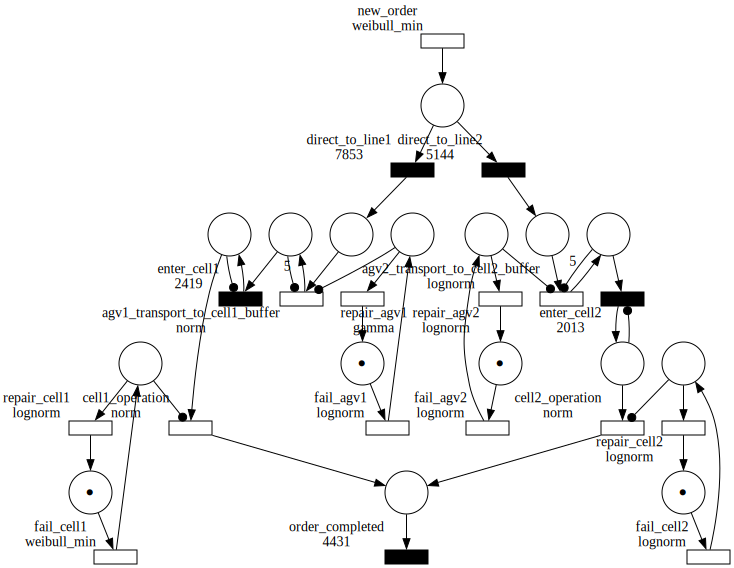

In [21]:
spn_visualization.draw_spn(rel_model, show=False, print_place_labels=False, rankdir="TB")

In [22]:
#spn_io.export_spn(rel_model, "cs_two_station.pkl")

In [11]:
#rel_model = spn_io.import_spn("output/models/cs_two_station.pkl")

In [12]:
mv = ModelValidator(rel_model,"m",event_log,state_log,event_log_unseen,state_log_unseen)
ci, y_mean, gt_ci, gt_mean, gt_ci_unseen, gt_mean_unseen = mv.validate_model(nr_replications=100, time = 1440, results_transition="order_completed", kpi="production volume")

--- SIMULATION RESULTS --- 

Y: [149, 143, 144, 148, 158, 137, 126, 144, 152, 163, 147, 170, 137, 139, 147, 163, 137, 139, 168, 144, 139, 160, 148, 119, 149, 145, 148, 154, 157, 142, 153, 127, 143, 167, 144, 138, 139, 151, 149, 154, 158, 143, 140, 136, 151, 131, 153, 154, 141, 150, 142, 142, 150, 159, 124, 154, 148, 175, 139, 160, 162, 138, 152, 150, 147, 146, 143, 157, 161, 170, 142, 137, 131, 149, 129, 138, 148, 138, 143, 139, 146, 134, 145, 150, 141, 142, 163, 147, 155, 155, 149, 152, 173, 155, 126, 140, 151, 167, 140, 143]
Mean: 147.25
Variance: 119.44
Standard deviation: 10.93
CI: (145.08145947722548, 149.41854052277452)

--- GROUND TRUTH --- 

n: 30
Y: [156, 130, 155, 162, 138, 139, 148, 144, 142, 172, 147, 144, 139, 153, 146, 159, 136, 141, 164, 130, 164, 146, 141, 144, 164, 125, 162, 151, 154, 135]
Mean: 147.7
CI: (143.32537978531985, 152.07462021468012)

--- GROUND TRUTH UNSEEN --- 

n: 30
Y: [151, 151, 141, 138, 165, 145, 146, 142, 138, 154, 144, 149, 169, 157, 151, 140, 152,

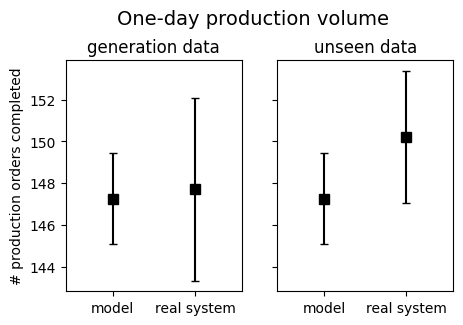

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3), sharey=True)
fig.suptitle('One-day production volume', fontsize=14, y=1.05)

ax1.set_xlim(right = 3, left = 0)
ax1.set_xticks([0.8, 2.2], ['model', 'real system'])
ax1.set_title("generation data")
ax1.set_ylabel("# production orders completed")

ax1.errorbar(x=0.8,y=y_mean,yerr=(ci[1]-ci[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
ax1.errorbar(x=2.2,y=gt_mean,yerr=(gt_ci[1]-gt_ci[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")

ax2.set_xlim(right = 3, left = 0)
ax2.set_xticks([0.8, 2.2], ['model', 'real system'])
ax2.set_title("unseen data")

ax2.errorbar(x=0.8,y=y_mean,yerr=(ci[1]-ci[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
ax2.errorbar(x=2.2,y=gt_mean_unseen,yerr=(gt_ci_unseen[1]-gt_ci_unseen[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")

#fig.savefig("validation1.pdf", format="pdf", bbox_inches="tight")

In [14]:
ci_downtime, y_mean_downtime, gt_ci_downtime, gt_mean_downtime, gt_ci_downtime_unseen, gt_mean_downtime_unseen = mv.validate_model(nr_replications=100, time = 1440, results_transition=["repair_agv1","repair_agv2","repair_cell1","repair_cell2"], kpi="resource downtime")

--- SIMULATION RESULTS --- 

Y: [2936.0066263276995, 2837.768055952847, 2705.035522613632, 2703.958130920652, 2697.6046932590216, 2605.1463061498525, 2875.6916631712356, 2814.5273800618743, 2857.7023776136084, 2852.5872605001186, 2749.242053225782, 2736.052090574153, 2672.0428198659074, 2830.046665755183, 2735.243158971465, 2815.595828399404, 2734.170555845064, 2738.3699828352715, 2733.2655501680147, 2753.36132609855, 2784.195633645675, 2795.6302984764843, 2674.0911854580672, 2844.7487189725757, 2834.137960607601, 2830.038600832265, 2740.276907400858, 2737.9093877525634, 2724.2324312580313, 2739.137206782777, 2947.0818287505926, 2716.4456012964038, 2713.050032653924, 2905.684934915411, 2883.735008464395, 2673.77483088559, 2785.5492236769683, 2617.9546804555384, 2648.002449782354, 2738.9888574252864, 2664.3014142239263, 2620.6317134066758, 2760.4308618235973, 2851.6763706387646, 2890.8338363720045, 2794.8833303036117, 2700.8367836911143, 2760.4314236118316, 2804.1559792632843, 2767.6878

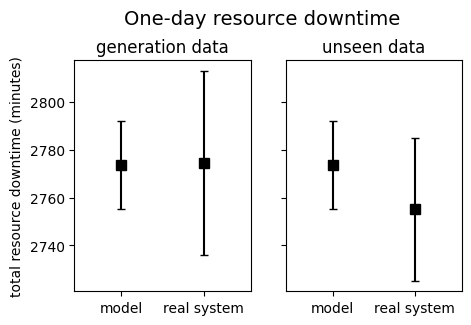

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3), sharey=True)
fig.suptitle('One-day resource downtime', fontsize=14, y=1.05)

ax1.set_xlim(right = 3, left = 0)
ax1.set_xticks([0.8, 2.2], ['model', 'real system'])
ax1.set_title("generation data")
ax1.set_ylabel("total resource downtime (minutes)")

ax1.errorbar(x=0.8,y=y_mean_downtime,yerr=(ci_downtime[1]-ci_downtime[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
ax1.errorbar(x=2.2,y=gt_mean_downtime,yerr=(gt_ci_downtime[1]-gt_ci_downtime[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")

ax2.set_xlim(right = 3, left = 0)
ax2.set_xticks([0.8, 2.2], ['model', 'real system'])
ax2.set_title("unseen data")

ax2.errorbar(x=0.8,y=y_mean_downtime,yerr=(ci_downtime[1]-ci_downtime[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
ax2.errorbar(x=2.2,y=gt_mean_downtime_unseen,yerr=(gt_ci_downtime_unseen[1]-gt_ci_downtime_unseen[0])/2,color="black", capsize=3,linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")

#fig.savefig("validation2.pdf", format="pdf", bbox_inches="tight")

In [16]:
mm = ModelManipulator(rel_model, time_unit="m")
new_config_downtime = mm.manipulate_model(time = 1440, results_transition=["repair_agv1","repair_agv2","repair_cell1","repair_cell2"], kpi = "resource repair time", transitions_to_manipulate_dynamic=["repair_agv1","repair_agv2","repair_cell1","repair_cell2"], handicap_range_dynamic = [1.0,3.1], step_dynamic = 0.2,nr_replications=30, type_dynamic="decrease")
new_config_prod_vol = mm.manipulate_model(time = 1440, results_transition=["order_completed"], kpi = "production volume", transitions_to_manipulate_dynamic=["repair_agv1","repair_agv2","repair_cell1","repair_cell2"], handicap_range_dynamic = [1.0,3.1], step_dynamic = 0.2,nr_replications=30, type_dynamic="decrease")

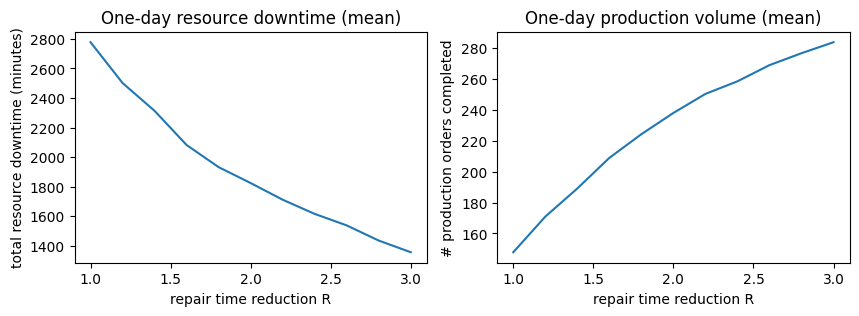

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(new_config_downtime.keys(),new_config_downtime.values())
ax1.set_title("One-day resource downtime (mean)")
ax1.set_xlabel("repair time reduction R")
ax1.set_ylabel("total resource downtime (minutes)")

ax2.plot(new_config_prod_vol.keys(),new_config_prod_vol.values())
ax2.set_title("One-day production volume (mean)")
ax2.set_xlabel("repair time reduction R")
ax2.set_ylabel("# production orders completed")

#fig.savefig("scenario1.pdf", format="pdf", bbox_inches="tight")